In [1]:
!pip install transformers
# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np 
import pandas 
import csv
import warnings
# import nltk
from google.cloud import storage
from io import BytesIO
import os
import string
import time
import pickle
import seaborn as sns
from pathlib import Path
import transformers
# !pip install torch

!pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1 -f https://download.pytorch.org/whl/cpu/torch_stable.html
import torch
import random
from random import randint
from datetime import datetime
import pandas as pd
from transformers import BertTokenizerFast,BertTokenizer, BertModel,BertConfig, BertForSequenceClassification, BertForMultipleChoice, Trainer, TrainingArguments
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer,RobertaTokenizerFast, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import matplotlib.pyplot as plt
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,multilabel_confusion_matrix,plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html


device(type='cpu')

---
# Upload data
---

In [2]:
# Add installed library dependencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin
print (PATH)

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin
/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games


## Set enviroment and bucket name

In [3]:
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID=PROJECT_ID[0]
REGION = "us-central1"
print(PROJECT_ID)

GCS_BUCKET = f"gs://{PROJECT_ID}-ml-vt-use-cases-topic-classification"
print(GCS_BUCKET)

friendly-tower-338419
gs://friendly-tower-338419-ml-vt-use-cases-topic-classification


## Initialize Vertex AI Python SDK
### Initialize the Vertex AI Python SDK with your GCP Project, Region, and Google Cloud Storage Bucket.

In [4]:
from google.cloud import aiplatform as vertexai
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

## upload data from bucket

In [5]:
# Instantiates a client
def get_gs_content_file(f):
    client = storage.Client()
    bucket_name = PROJECT_ID+'-ml-vt-use-cases-topic-classification'
    file='Dataset/'+f
    bucket = client.get_bucket(bucket_name)
    blob = storage.blob.Blob(file,bucket)
    content = blob.download_as_string()
    return BytesIO(content)

In [6]:
processed_text_final = pandas.read_csv(get_gs_content_file('outputfile_text_processed.csv'))

y_label_code = np.loadtxt(get_gs_content_file('numeric_label_topic.txt'), dtype=int)
y_label_code=y_label_code.tolist()
print(len(y_label_code))

new_dict = np.load(get_gs_content_file("myDictionary_labels.npy"), allow_pickle='TRUE')
new_dict.item()

800803


{'CORPORATE/INDUSTRIAL': 'CORPORATE/INDUSTRIAL',
 'ECONOMICS': 'ECONOMICS',
 'GOVERNMENT/SOCIAL': 'GOVERNMENT/SOCIAL',
 'MARKETS': 'MARKETS'}

In [7]:
y_label_code_column=[]
for row in y_label_code:
    lab=(''.join(map(str, row)))
    y_label_code_column.append(lab)
len(y_label_code_column)

800803

In [8]:
Data_Set=pandas.DataFrame({'text':list(processed_text_final['text']),'target':y_label_code_column})
Data_Set.head(1)

,text,target
0,uk share market unlikely make much headway nex...,0001


In [9]:
del y_label_code
del y_label_code_column
del processed_text_final

---
# Embeddings tecniques
---

## Preparazione dataset

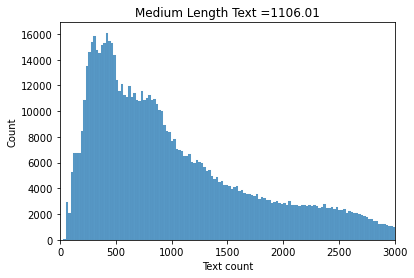

In [10]:
def time_calculate(bool_t=True,start_time=0):
    if bool_t==True:
        print('START: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        return time.time()
    else:
        end_time=time.time()
        print('END: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        giorno_in_sec=86400
        giorni=(int(end_time)-int(start_time))//giorno_in_sec
        t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
        print("tempo impiegato "+str(giorni)+'d:'+t)
        return t
    
def plot_token_occ(x,start,end, genere,title,leng=True):
    token_lens_occ = []
    for txt in x:
        if leng:
            txtp=str(txt)
        else:
            txtp=str(txt).split(' ')
        token_lens_occ.append(len(txtp))
    media=np.mean(token_lens_occ)
    sns.histplot(token_lens_occ)
    plt.xlim([start,end])
    plt.xlabel('Text count')
    plt.title(title+genere+" ="+ str(round(media,2)))
    plt.show()
    return token_lens_occ

token_lens_occ=plot_token_occ(Data_Set['text'].tolist(),0,3000,'','Medium Length Text')

In [11]:
model_name = "bert-base-uncased"
max_length = 1000

tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

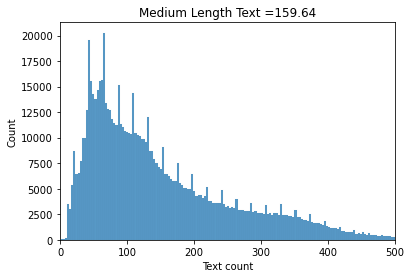

In [12]:
plot_token_occ(Data_Set['text'].tolist(),0,500,'','Medium Length Text',False)
print()

In [13]:
def verifica(list_):
    ver={'1_label':0,'2_label':0,'3_label':0,'4_label':0}
    for v in list_:
        l=sum([int(x) for x in v])
        if l>=2:
            ver['2_label']+=1
        elif l>=3:
            ver['3_label']+=1
        elif l>=4:
            ver['4_label']+=1
        else:
            ver['1_label']+=1
    print(ver)
verifica(Data_Set['target'])

{'1_label': 681931, '2_label': 118872, '3_label': 0, '4_label': 0}


In [14]:
#ulteriore riduzione
delete=0
start_row=35
end_row=150 #len(Data_Set)
print('prima--->',len(Data_Set),'!')
start_time=time_calculate()
delete=len(Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))> end_row) ])+len(Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))< start_row)])
Data_Set = Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))<= end_row) ]
Data_Set = Data_Set[(Data_Set['text'].map(lambda x: len(x.split(' ')))>= start_row) ]
Data_Set = Data_Set.reset_index(drop=True)
end_time=time_calculate(bool_t=False,start_time=start_time)
print('ora--->',len(Data_Set),', eliminati',delete,'record su',800803 ,'!')

prima---> 800803 !
START:  2022-02-16 16:07
END:  2022-02-16 16:07
tempo impiegato 0d:00h:00m:20s
ora---> 439176 , eliminati 361627 record su 800803 !


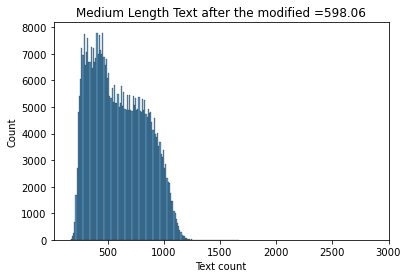

In [15]:
token_lens_occ=plot_token_occ(Data_Set['text'].tolist(),20,3000,'','Medium Length Text after the modified')

In [16]:
verifica(Data_Set['target'])

{'1_label': 384254, '2_label': 54922, '3_label': 0, '4_label': 0}


In [17]:
def crea_label_vector(Data_Set):
    y_label_code_reduced=[]
    for index, row in Data_Set.iterrows():
        row_t=(list(row['target']))
        row_t=[int(x) for x in row_t]
        y_label_code_reduced.append(row_t)
    print('size ridotta',len(y_label_code_reduced))
    return y_label_code_reduced
class_names_list=new_dict.item()
target_names=[x for x in class_names_list.keys()]
y_label_code_reduced=crea_label_vector(Data_Set)

size ridotta 439176


In [18]:
def stat_ds(y_label_code_reduced):
    x=np.zeros(len(y_label_code_reduced[0]),dtype=int)
    for v in y_label_code_reduced:
        x=x+v
    c=0
    for v in x:
        if v==0:
            c+=1
    print(x)
    print('esempi = 0 :',c)
    #percentuali sull'intero dataset
    xx=x.copy()
    z=[]
    for l in xx:
        z.append(str(round((l/len(Data_Set))*100,1))+'%')
    print(z)
    return x#,[float(x[:4]) for x in z]
    
stat_ds_list=stat_ds(y_label_code_reduced)

[244323  55827  94588 109071]
esempi = 0 : 0
['55.6%', '12.7%', '21.5%', '24.8%']


In [19]:
def _red_list_bal(y_label_code_reduced):
    c=stat_ds(y_label_code_reduced)
    min_l=min(c)
    red=[0,0,0,0]
    ind=0
    for i in c:
        if i!=min_l:
            val=c[ind]#int((i/100)*len(Data_Set))
            red[ind]=val-min_l#int((min_l/100)*len(Data_Set))
        else:
            red[ind]=1
        ind+=1
    return red

In [20]:
def indx_permutati(Data_Set):
    random.seed(42)
    ind_ds=random.sample(range(len(Data_Set)), len(Data_Set))
    return ind_ds

In [21]:
def bilancia(Data_Set):
    size_prima=len(Data_Set)
    conta1=0
    conta2=0
    conta3=0
    conta4=0
    index=0
    red=_red_list_bal(y_label_code_reduced)
    indx_perm=indx_permutati(Data_Set)
    index_list=[]
    row_list=Data_Set['target'].tolist()
    for row_ind in indx_perm:
        row=row_list[row_ind]
        row_t=[int(x) for x in row]
        if sum(row_t)==1:
            if row_t[0]==1 and conta1<red[0]:
                index_list.append(row_ind)
                conta1+=1
            if row_t[1]==1 and conta1<red[1]:
                index_list.append(row_ind)
                conta2+=1
            if row_t[2]==1 and conta3<red[2]:
                index_list.append(row_ind)
                conta3+=1
            if row_t[3]==1 and conta4<red[3]:
                index_list.append(row_ind)
                conta4+=1
        
        index+=1
        if index%100000==0 and index!=0:
            print('analizzati',index)
    Data_Set.drop(index_list, inplace=True)
    Data_Set.reset_index(drop=True)
    print('eliminati come prima label',conta1,'\neliminati come seconda label',conta2,'\neliminati come terza label',conta3,'\neliminati come quarta label',conta4,'\nsize ridotta da',size_prima,'a',len(Data_Set))

start_time=time_calculate()
bilancia(Data_Set)
end_time=time_calculate(bool_t=False,start_time=start_time)

START:  2022-02-16 16:07
[244323  55827  94588 109071]
esempi = 0 : 0
['55.6%', '12.7%', '21.5%', '24.8%']
analizzati 100000
analizzati 200000
analizzati 300000
analizzati 400000
eliminati come prima label 188496 
eliminati come seconda label 1 
eliminati come terza label 38761 
eliminati come quarta label 53244 
size ridotta da 439176 a 158674
END:  2022-02-16 16:07
tempo impiegato 0d:00h:00m:02s


In [22]:
y_label_code_reduced=crea_label_vector(Data_Set)
stat_ds(y_label_code_reduced)

size ridotta 158674
[55827 55826 55827 55827]
esempi = 0 : 0
['35.2%', '35.2%', '35.2%', '35.2%']


array([55827, 55826, 55827, 55827])

In [23]:
token_lens=[]
print('Start tokenizzation')
token_lens = []
i=0
max_len=512#len(max(Data_Set_emb['text']))
stampa_ogni=50000

start_time=time_calculate()
x=Data_Set['text'].tolist()
for txt in x:
    txt=str(txt)
    tokens = tokenizer.encode(txt, max_length=max_len, truncation=True)
    token_lens.append(len(tokens))
    if i%stampa_ogni==0 and i!=0:
        print('tokenizzati',i)
        end_time=time_calculate(bool_t=False,start_time=start_time)
        start_time=time_calculate()
    i+=1
print("End tokenizzation")
len(token_lens)

Start tokenizzation
START:  2022-02-16 16:07
tokenizzati 50000
END:  2022-02-16 16:08
tempo impiegato 0d:00h:00m:25s
START:  2022-02-16 16:08
tokenizzati 100000
END:  2022-02-16 16:08
tempo impiegato 0d:00h:00m:25s
START:  2022-02-16 16:08
tokenizzati 150000
END:  2022-02-16 16:09
tempo impiegato 0d:00h:00m:25s
START:  2022-02-16 16:09
End tokenizzation


158674

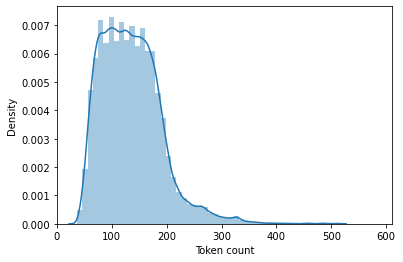

In [24]:
def plot_token_occ(token_lens,max_len):
    sns.distplot(token_lens)
    plt.xlim([0, max_len+10]);
    plt.xlabel('Token count');
plot_token_occ(token_lens,max_len=600)

# Fine Tuning Transformer for MultiLabel Text Classification

#### Technical Details

Questo script fa leva su più strumenti progettati da altri team. Dettagli degli strumenti utilizzati di seguito.
 - Data: 
	 - Stiamo usando i dati reuters 
   - Ci sono righe di dati. Dove ogni riga ha il seguente punto dati: 
		 - Topic Text
		 - `CORPORATE/INDUSTRIAL`
		 - `ECONOMICS`
		 - `GOVERNMENT/SOCIAL`
		 - `MARKETS`
Ogni commento può essere contrassegnato per più categorie. Se il commento lo è `ECONOMICS` e `MARKETS`, quindi per entrambe le intestazioni il valore sarà `1` e per gli altri sarà `0`.

In [25]:
X = list(Data_Set['text'])
y = y_label_code_reduced
new_df = pandas.DataFrame({'text':X, 'topic':y})
print(len(new_df))
new_df.head()

158674


,text,topic
0,pregnant ira bomb suspect released bail friday...,"[0, 0, 1, 0]"
1,german coffee roaster eduscho gmbh amp co kg f...,"[1, 0, 0, 1]"
2,millfeed prices mostly steady friday ahead u.s...,"[0, 0, 0, 1]"
3,european raw cotton markets quiet mood despite...,"[0, 0, 0, 1]"
4,year march 31 1998 billions yen unless specifi...,"[1, 0, 0, 0]"


<a id='section03'></a>
### Preparing the Dataset and Dataloader

#### *CustomDataset* Dataset Class
- Questa classe è definita per accettare il `tokenizer`, `dataframe` e `max_length` come input e generare output e tag tokenizzati utilizzati dal modello BERT per la formazione. 
- Stiamo utilizzando il tokenizzatore BERT per tokenizzare i dati nel file `comment_text` colonna del frame di dati.
- Il tokenizzatore utilizza il metodo `encode_plus` per eseguire la tokenizzazione e generare gli output necessari, vale a dire
: `ids`, `attention_mask`, `token_type_ids`
---
- *Questa è la prima differenza tra distilbert e bert, dove il tokenizer genera token_type_ids in caso di Bert*
---
- `targest` è l'elenco delle categorie etichettate come `0` o `1` nel dataframe. 
- La classe *CustomDataset* viene utilizzato per creare 2 set di dati, per l'addestramento e per la convalida.
- *Training Dataset* viene utilizzato per mettere a punto il modello: **70% dei dati originali** 
- *Set di dati di convalida* viene utilizzato per valutare le prestazioni del modello. Il modello non ha visto questi dati durante l'allenamento. 

#### Dataloader
- Il caricatore di dati viene utilizzato per creare un caricatore di dati di addestramento e convalida che carica i dati nella rete neurale in un modo definito. Ciò è necessario perché tutti i dati del set di dati non possono essere caricati in memoria in una volta, quindi è necessario controllare la quantità di dati caricati in memoria e quindi passati alla rete neurale.
- Questo controllo si ottiene utilizzando i parametri come `batch_size` e `max_len`.
- I caricatori di dati di addestramento e convalida vengono utilizzati rispettivamente nella parte di addestramento e convalida del flusso


In [26]:
# Defining some key variables that will be used later on in the training
iper_parameters={}
iper_parameters['MAX_LEN'] = 512 #200
iper_parameters['TRAIN_SIZE'] = 0.7
iper_parameters['TRAIN_BATCH_SIZE'] = 8
iper_parameters['VALID_BATCH_SIZE'] = 4
iper_parameters['EPOCHS'] = 1
iper_parameters['LEARNING_RATE'] = 1e-05

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [28]:
def crea_label_vector_train(Data_Set):
    y_label_code_reduced=[]
    for row in Data_Set:
        row_t=(list(row))
        row_t=[int(x) for x in row_t]
        y_label_code_reduced.append(row_t)
    return y_label_code_reduced

In [29]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = crea_label_vector_train(self.data.topic)
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [30]:
# Creating the dataset and dataloader for the neural network


train_dataset=new_df.sample(frac=iper_parameters['TRAIN_SIZE'],random_state=42).reset_index(drop=True)
val_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)

validation_dataset=val_dataset.sample(frac=0.66,random_state=42).reset_index(drop=True)
test_dataset=val_dataset.drop(validation_dataset.index).reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(validation_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, iper_parameters['MAX_LEN'])
validation_set = CustomDataset(validation_dataset, tokenizer, iper_parameters['MAX_LEN'])
test_set = CustomDataset(test_dataset, tokenizer, iper_parameters['MAX_LEN'])

FULL Dataset: (158674, 2)
TRAIN Dataset: (111072, 2)
VALIDATION Dataset: (31417, 2)
TEST Dataset: (16185, 2)


In [31]:
train_params = {'batch_size': iper_parameters['TRAIN_BATCH_SIZE'] ,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': iper_parameters['VALID_BATCH_SIZE'],
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)
test_loader=DataLoader(test_set, **test_params)

# BERT

conda install pytorch<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - Creeremo una rete neurale con il `BERTClass`. 
 - Questa rete avrà il modello `Bert`.  Seguito da un `Droput` e `Linear Layer`. Sono aggiunti rispettivamente ai fini della **Regolarizzazione** e della **Classificazione**. 
 - Nel loop in avanti, ci sono 2 uscite dal `BertModel` layer.
 - Il secondo output `output_1` o chiamato `pooled output` è passato al `Drop Out layer` e l'output successivo viene dato al `Linear layer`. 
 - Prendere nota del numero di dimensioni per `Linear Layer` è **4** perché questo è il numero totale di categorie in cui stiamo cercando di classificare il nostro modello.
 - I dati saranno trasmessi al `BertClass` come definito nel set di dati.   
 - Gli output del livello finale sono ciò che verrà utilizzato per calcolare la perdita e per determinare l'accuratezza della previsione dei modelli. 
 - Inizieremo un'istanza della rete chiamata  `model`. Questa istanza verrà utilizzata per l'addestramento e quindi per salvare il modello addestrato finale per l'inferenza futura. 
 
#### Loss Function and Optimizer
 -La loss è definita nella cella successiva come `loss_fn`.
 - Come definito sopra, la funzione di perdita utilizzata sarà una combinazione di Binary Cross Entropy che viene implementata come `BCELogits Loss` in PyTorch
 - `Optimizer` è definito nella cella successiva.
 - `Optimizer` viene utilizzato per aggiornare i pesi della rete neurale per migliorarne le prestazioni.

In [32]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 4)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [33]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=iper_parameters['LEARNING_RATE'])

<a id='section05'></a>
### Fine Tuning the Model

Dopo tutto lo sforzo di caricare e preparare i dati e i set di dati, creare il modello e definirne la perdita e l'ottimizzatore. Questo è probabilmente il passaggio più semplice del processo. 

Qui definiamo una funzione di addestramento che addestra il modello sul set di dati di addestramento creato sopra, il numero di volte specificato (EPOCH), Un'epoca definisce quante volte i dati completi verranno passati attraverso la rete. 

In questa funzione si verificano i seguenti eventi per ottimizzare la rete neurale: 
- Il caricatore di dati passa i dati al modello in base alla dimensione del batch. 
- L'output successivo del modello e la categoria effettiva vengono confrontati per calcolare la perdita. 
- Il valore di perdita viene utilizzato per ottimizzare i pesi dei neuroni nella rete. 
- Dopo ogni 5000 passi il valore della perdita viene stampato nella console.

Come puoi vedere solo in 1 epoca dal passaggio finale, il modello funzionava con una minuscola perdita di 0,022, ovvero l'output di rete è estremamente vicino all'output effettivo.

In [34]:
def load_model(model_path, model,device='cpu'):
    if model_path==None:
        return
    print('MODEL ALREADY TRAINED')
    
    with open(model_path, 'rb') as pickle_file:
        if device=='cpu':
            model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        else:
            model.load_state_dict(torch.load(model_path))
    return model

def save_model(model,model_path):
    with open(model_path, 'wb') as pickle_file:
        torch.save(model.state_dict(), model_path)
    print('SAVED')

def verifica_esistenza_modello(file_name):
    esiste=False
    try:
        my_file = Path(file_name)
        if my_file.is_file():
            esiste=True
    except IOError:
        print("File not accessible")
    print("Il file  esiste?",esiste)
    return esiste

def load_check(_path):
    with open(_path, 'rb') as pickle_file:
        file_upload = pickle.load(pickle_file)
    return file_upload

def load_evaluetion(output_path,target_path):
    output=load_check(output_path)
    target=load_check(target_path)
    return output,target

def save_evaluetion(output,targets,output_path,target_path):
    with open(output_path, 'wb') as pickle_file:
        pickle.dump(output, pickle_file)
    print('SAVED')
    with open(target_path, 'wb') as pickle_file:
        pickle.dump(targets, pickle_file)
    print('SAVED')
    
def set_checkpoint(path_,check):
    with open(path_, 'w') as file:
        file.truncate(0)
        file.write(str(check))

def load_checkpoint(path_):
    with open(path_, 'r') as file:
        load_check=int(file.readline())
    return load_check

path_na='/home/jupyter/mattia_gatto/text-mining-use-cases/src/use_cases/use_case_topic_classification/Models/'
path_name=path_na+'BERT'
model_path = path_name+'/bert_model_nlp.pt'
output_path= path_name+'/bert_model_nlp_evaluetion_outputs'
target_path= path_name+'/bert_model_nlp_evaluetion_targets'
check_path = path_name+'/checkpoint.txt'
verifica=verifica_esistenza_modello(model_path)

Il file  esiste? True


In [35]:
def train(epoch):
    model.train()
    start_time=time_calculate()
    i=0
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        if i%500==0 and i!=0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            end_time=time_calculate(bool_t=False,start_time=start_time)
            print('-'*50)
            start_time=time_calculate()
            
        i+=1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    save_model(model,model_path)  
    # return model_train

In [36]:
if verifica==False:
    for epoch in range(iper_parameters['EPOCHS']):
        print('START EPOCH',epoch+1)
        start_time=time_calculate()
        print('-'*50)
        train(epoch)
        print('-'*50)
        end_time=time_calculate(bool_t=False,start_time=start_time)
        set_checkpoint(check_path,epoch+1)
        print('END EPOCH',epoch+1)
else:
    epoca=load_checkpoint(check_path)
    model=load_model(model_path, model)
    if epoca!=iper_parameters['EPOCHS']:
        for epoch in range(epoca,iper_parameters['EPOCHS']):
            print('START EPOCH',epoch+1)
            start_time=time_calculate()
            print('-'*50)
            train(epoch)
            print('-'*50)
            end_time=time_calculate(bool_t=False,start_time=start_time)
            set_checkpoint(check_path,epoch+1)
            print('END EPOCH',epoch+1)

MODEL ALREADY TRAINED


<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As defined above to get a measure of our models performance we are using the following metrics. 
- Accuracy Score
- F1 Micro
- F1 Macro

We are getting amazing results for all these 3 categories just by training the model for 1 Epoch.

In [37]:
def plt_roc_curve(y_val,y_pred,size=(6,6)):
    # Compute ROC curve and ROC area for each class
    y_test=np.array(y_val)
    y_score=np.array(y_pred)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test[i,:], y_score[i,:])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.rcParams["figure.figsize"] = size
    plt.plot(
      fpr[2],
      tpr[2],
      color="darkorange",
      lw=2,
      label="ROC curve (area = %0.2f)" % roc_auc[2],)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    auc = roc_auc_score(y_val, y_pred, average=None)#metrics.auc(y_val,y_pred)
    plt.title('AUC = '+str(round(sum(auc)/len(auc),3)))
    plt.show()

def plot_classification_report(classification_report, title='', cmap='RdBu',num_class=4,size=(6,7)):
    title_='Classification report '+title
    plt.title(title_)
    plt.rcParams["figure.figsize"] = size
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) )]:
        t = line.strip().split()
        if len(t) < 2: continue
        if t[1]=='avg':
            classes.append(t[0]+t[1])
            start=2
        else:
            classes.append(t[0])
            start=1
        if t[0]== 'accuracy':
            v=[float(),float(),float(t[1])]
        else:
            v = [float(x) for x in t[start: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    class_names[len(class_names)-1]=class_names[len(class_names)-1]+' avg'
    class_names[len(class_names)-2]=class_names[len(class_names)-2]+' avg'
    class_names[len(class_names)-3]=class_names[len(class_names)-3]+' avg'
    class_names[len(class_names)-4]=class_names[len(class_names)-4]+' avg'
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    plotMat.insert(num_class, plotMat[3])
    yticklabels.insert(num_class, '')
    data=pd.DataFrame(np.array(plotMat))
    data[0][num_class]=None
    data[1][num_class]=None
    data[2][num_class]=None
    sns.heatmap(data, annot=True,xticklabels=xticklabels,yticklabels=yticklabels)
    plt.show()


In [38]:
def validation(epoch):
    model.eval()
    topic_predict_targets=[]
    topic_predict_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            topic_predict_targets.extend(targets.cpu().detach().numpy().tolist())
            topic_predict_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return topic_predict_outputs, topic_predict_targets

In [39]:
start_time=time_calculate()
print('-'*100)
for epoch in range(iper_parameters['EPOCHS']):
    print(f'Epoch: {epoch}')
    if verifica_esistenza_modello(output_path) and verifica_esistenza_modello(target_path):
        outputs,targets=load_evaluetion(output_path,target_path)
    else:
        outputs, targets = validation(epoch) 
        save_evaluetion(outputs, targets, output_path,target_path)
    outputs = np.array(outputs) >= 0.5 #Emette una matrice booleana. Il problema è che ha la stessa forma di prima, ma quando si valuta l'accuratezza è necessario un vettore di etichette
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    
    y_pred = outputs
    classification_report_=metrics.classification_report(targets,y_pred,target_names=list(new_dict.item().keys()))
    # print(classification_report_)
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
      
    end_time=time_calculate(bool_t=False,start_time=start_time)
    print('-'*100)
    start_time=time_calculate()

START:  2022-02-16 16:09
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.8645956011076805
F1 Score (Micro) = 0.9452948102526946
F1 Score (Macro) = 0.9452807564781107
END:  2022-02-16 16:09
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:09


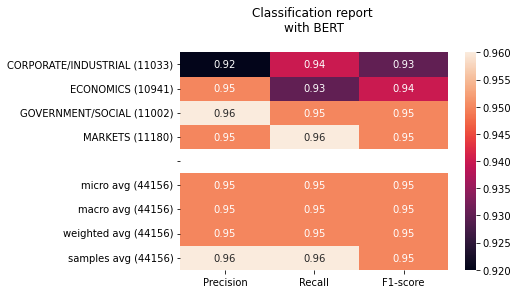

In [40]:
# plt_roc_curve(targets,y_pred,size=(10,6))
plot_classification_report(classification_report_,title='\nwith BERT\n',size=(7,7))

# RoBERTa

In [41]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataset=new_df.sample(frac=iper_parameters['TRAIN_SIZE'],random_state=42).reset_index(drop=True)
val_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)

validation_dataset=val_dataset.sample(frac=0.66,random_state=42).reset_index(drop=True)
test_dataset=val_dataset.drop(validation_dataset.index).reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(validation_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, iper_parameters['MAX_LEN'])
validation_set = CustomDataset(validation_dataset, tokenizer, iper_parameters['MAX_LEN'])
test_set = CustomDataset(test_dataset, tokenizer, iper_parameters['MAX_LEN'])
train_params = {'batch_size': iper_parameters['TRAIN_BATCH_SIZE'] ,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': iper_parameters['VALID_BATCH_SIZE'],
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)
test_loader=DataLoader(test_set, **test_params)

FULL Dataset: (158674, 2)
TRAIN Dataset: (111072, 2)
VALIDATION Dataset: (31417, 2)
TEST Dataset: (16185, 2)


In [42]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = transformers.RobertaModel.from_pretrained('roberta-base', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 4)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = RoBERTaClass()
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RoBERTaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [43]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=iper_parameters['LEARNING_RATE'])

In [44]:
path_name=path_na+'ROBERTA'
model_path = path_name+'/roberta_model_nlp.pt'
output_path= path_name+'/roberta_model_nlp_evaluetion_outputs'
target_path= path_name+'/roberta_model_nlp_evaluetion_targets'
check_path=path_name+'/checkpoint.txt'
verifica=verifica_esistenza_modello(model_path)

Il file  esiste? True


In [45]:
if verifica==False:
    for epoch in range(iper_parameters['EPOCHS']):
        print('START EPOCH',epoch+1)
        start_time=time_calculate()
        print('-'*50)
        train(epoch)
        print('-'*50)
        end_time=time_calculate(bool_t=False,start_time=start_time)
        set_checkpoint(check_path,epoch+1)
        print('END EPOCH',epoch+1)
else:
    epoca=load_checkpoint(check_path)
    model=load_model(model_path, model)
    if epoca!=iper_parameters['EPOCHS']:
        for epoch in range(epoca,iper_parameters['EPOCHS']):
            print('START EPOCH',epoch+1)
            start_time=time_calculate()
            print('-'*50)
            train(epoch)
            print('-'*50)
            end_time=time_calculate(bool_t=False,start_time=start_time)
            set_checkpoint(check_path,epoch+1)
            print('END EPOCH',epoch+1)

MODEL ALREADY TRAINED


In [46]:
start_time=time_calculate()
print('-'*100)
for epoch in range(iper_parameters['EPOCHS']):
    print(f'Epoch: {epoch}')
    if verifica_esistenza_modello(output_path) and verifica_esistenza_modello(target_path):
        outputs,targets=load_evaluetion(output_path,target_path)
    else:
        outputs, targets = validation(epoch) 
        save_evaluetion(outputs, targets, output_path,target_path)
    outputs = np.array(outputs) >= 0.5 #Emette una matrice booleana. Il problema è che ha la stessa forma di prima, ma quando si valuta l'accuratezza è necessario un vettore di etichette
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    
    y_pred = outputs
    classification_report_=metrics.classification_report(targets,y_pred,target_names=list(new_dict.item().keys()))
    # print(classification_report_)
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
      
    end_time=time_calculate(bool_t=False,start_time=start_time)
    print('-'*100)
    start_time=time_calculate()

START:  2022-02-16 16:09
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.8574975331826719
F1 Score (Micro) = 0.9418032786885245
F1 Score (Macro) = 0.9416353543751037
END:  2022-02-16 16:09
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:09


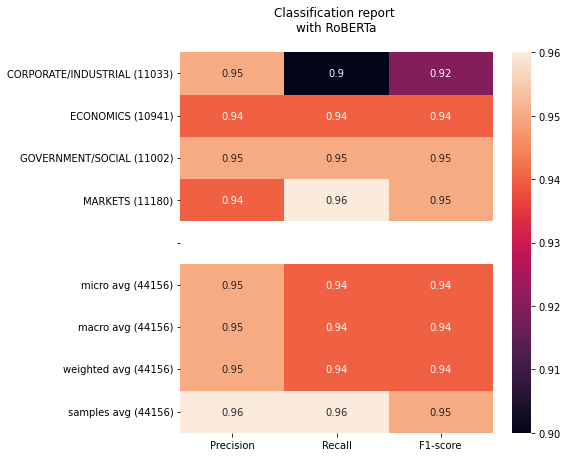

In [47]:
# plt_roc_curve(targets,y_pred,size=(10,6))
plot_classification_report(classification_report_,title='\nwith RoBERTa\n',size=(7,7))

## Bert_Muse

In [48]:
processed_text_final_multilingual = pandas.read_csv(get_gs_content_file('rcv_multilingual.csv'))
pd_multi=pandas.DataFrame(processed_text_final_multilingual)

In [49]:
s1=28964
text_chinese=pd_multi.iloc[0: s1]
text_chinese=text_chinese.reset_index(drop=True)

s2=37805
text_portuguese=pd_multi.iloc[s1: s2]
text_portuguese=text_portuguese.reset_index(drop=True)

s3=55292
text_russian=pd_multi.iloc[s2: s3]
text_russian=text_russian.reset_index(drop=True)

s4=120792
text_japanese=pd_multi.iloc[s3: s4]
text_japanese=text_japanese.reset_index(drop=True)

s5=139448
text_spanish=pd_multi.iloc[s4: s5]
text_spanish=text_spanish.reset_index(drop=True)

s6=155179
text_swedish=pd_multi.iloc[s5: s6]
text_swedish=text_swedish.reset_index(drop=True)

s7=164588
text_norwegian=pd_multi.iloc[s6: s7]
text_norwegian=text_norwegian.reset_index(drop=True)

s8=166383
text_dutch=pd_multi.iloc[s7: s8]
text_dutch=text_dutch.reset_index(drop=True)

s9=282596
text_german=pd_multi.iloc[s8: s9]
text_german=text_german.reset_index(drop=True)

s10=362372
text_spanish_latam=pd_multi.iloc[s9: s10]
text_spanish_latam=text_spanish_latam.reset_index(drop=True)

s11=373557
text_danish=pd_multi.iloc[s10: s11]
text_danish=text_danish.reset_index(drop=True)

s12=458952
text_french=pd_multi[s11: s12]
text_french=text_french.reset_index(drop=True)

s13=len(pd_multi)
text_italian=pd_multi.iloc[s12: s13]
text_italian=text_italian.reset_index(drop=True)

datasets_multi=[text_chinese,text_danish,text_dutch,text_french,text_german,text_italian,text_japanese,text_norwegian,text_portuguese,text_russian,text_spanish,text_spanish_latam,text_swedish]

In [50]:
industry_codes=pandas.read_csv(get_gs_content_file('codici/industry_codes.csv'))
region_codes=pandas.read_csv(get_gs_content_file('codici/region_codes.csv'))
topic_codes=pandas.read_csv(get_gs_content_file('codici/topic_codes.csv'))

In [51]:
def splitta_codes(df_without_duplicates):
    cod=df_without_duplicates['code']
    industry_codes_list=industry_codes['industry_code'].values
    region_codes_list=region_codes['region_code'].values
    topic_codes_list=topic_codes['topic_code'].values
    df_code_industry=[]
    df_code_region=[]
    df_code_topic=[]

    i=0
    check=200000
    start = time.time()
    for code_record in cod.values:
        codici=code_record.split(',')
        single_industry=[]
        single_region=[]
        single_topic=[]
        for c in codici:
            if c in industry_codes_list:
                single_industry.append(c)
            elif c in region_codes_list:
                single_region.append(c)
            elif c in topic_codes_list:
                single_topic.append(c)
        df_code_industry.append(str(",".join(single_industry)))
        df_code_region.append(str(",".join(single_region)))
        df_code_topic.append(str(",".join(single_topic))) 
        if(i%check==0 and i!=0):
            print('elaborati',i,'record!')
        i+=1

    end = time.time()
    t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end)-int(start)))
    print("tempo impiegato per dividere le colonna in tre(region_codes, industries_codes e topics_codes) vettori è di: "+t)
    df_without_duplicates['industry_codes']=df_code_industry
    df_without_duplicates['region_codes']=df_code_region
    df_without_duplicates['topic_codes']=df_code_topic

def aggrega_etichette_macro_gruppo(mydict):
    topics_aggregated_key_macro={}
    for cod in mydict.keys():
        radice=cod[:1]
        radice2=cod[1]
        if radice=='E':
            topics_aggregated_key_macro[cod]= 'ECONOMICS'
        elif radice=='C':
            topics_aggregated_key_macro[cod]= 'CORPORATE/INDUSTRIAL'
        elif radice=='M':
            topics_aggregated_key_macro[cod]= 'MARKETS'
        elif radice=='G':
            topics_aggregated_key_macro[cod]= 'GOVERNMENT/SOCIAL'
        else:
            topics_aggregated_key_macro[cod]= cod#mydict[cod]
        # print('Aggrego',cod,' con desc:',mydict[cod],' nella radice:',topics_aggregated_key_macro[cod])
    return topics_aggregated_key_macro

def Y_label_codes(dataset,name_code):
    y_topic_dict={}
    for nam in name_code:
        y_topic_dict[nam]=0
    codes=list(dataset['topic_codes'].values)
    y_label_code=[]
    occ=0
    occ_print=200000
    for record_codes in codes:
        if str(record_codes)!='nan':
            record_codes_list=record_codes.split(',')
            label=y_topic_dict.copy()
            for cod in record_codes_list:
                if cod!='':
                    label[cod]+=1
                else:
                    dataset.drop(occ)
            y_label_code.append(list(label.values()))
        else:
            y_label_code.append(list(0 for i in range(0, 4)))
        if (occ%occ_print==0 and occ!=0) or (occ==(len(codes)-1)):
            print('analizzati',occ,'record')
        occ+=1
    return y_label_code,y_topic_dict

def aggrega_codes(df,lista_eliminati):
    cod=df['topic_codes']
    topic_codes=pandas.read_csv(get_gs_content_file('codici/topic_codes.csv'))
    topic_codes_list=topic_codes['topic_code'].values
    df_code_topic=[]
    i=0
    check=200000
    start = time.time()
    for code_record in cod.values:
        codici=code_record.split(',')
        single_topic=[]
        for c in codici:
            if c in (list(lista_eliminati.keys())):
                single_topic.append(lista_eliminati[c])
            else:
                single_topic.append(c)
        df_code_topic.append(str(",".join(set(single_topic)))) 
        if(i%check==0 and i!=0):
            print('elaborati',i,'record!')
        i+=1

    end = time.time()
    t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end)-int(start)))
    print("tempo impiegato per accorpare le etichette nella colonna topics_codes è di: "+t)
    df['topic_codes']=df_code_topic
    return df

In [52]:
import codecs
mydict = {}
reader = csv.reader(codecs.iterdecode(get_gs_content_file('codici/topic_codes.csv'), 'utf-8'))
dict_from_csv = {rows[0]:rows[1] for rows in reader}
del dict_from_csv['topic_code']
topics_aggregated_key_macro=aggrega_etichette_macro_gruppo(dict_from_csv)
del topics_aggregated_key_macro['1POL']
del topics_aggregated_key_macro['2ECO']
del topics_aggregated_key_macro['3SPO']
del topics_aggregated_key_macro['4GEN']
del topics_aggregated_key_macro['6INS']
del topics_aggregated_key_macro['7RSK']
del topics_aggregated_key_macro['8YDB']
del topics_aggregated_key_macro['9BNX']
del topics_aggregated_key_macro['ADS10']
del topics_aggregated_key_macro['BNW14']
del topics_aggregated_key_macro['BRP11']
del topics_aggregated_key_macro['PRB13']

In [53]:
i=0
for i in range (len(datasets_multi)):
    df_prova_multilingual=datasets_multi[i].copy()
    df_without_duplicates_multilingual = df_prova_multilingual.drop_duplicates()
    df_without_duplicates_multilingual.reset_index(drop=True,inplace=True)
    print(len(df_without_duplicates_multilingual))
    df_without_duplicates_multilingual=df_without_duplicates_multilingual.dropna( subset=['text','code']).reset_index(drop=True)
    splitta_codes(df_without_duplicates_multilingual)
    datasets_multi[i]=df_without_duplicates_multilingual[['text','topic_codes']]
    datasets_multi[i]=aggrega_codes(datasets_multi[i],topics_aggregated_key_macro)
    y_label_code,y_topic_dict=Y_label_codes(datasets_multi[i], np.unique(list(topics_aggregated_key_macro.values())))
    datasets_multi[i]['topic_code']=y_label_code

[text_chinese,text_danish,text_dutch,text_french,text_german,text_italian,text_japanese,text_norwegian,text_portuguese,text_russian,text_spanish,text_spanish_latam,text_swedish]

27514
tempo impiegato per dividere le colonna in tre(region_codes, industries_codes e topics_codes) vettori è di: 00h:00m:07s
tempo impiegato per accorpare le etichette nella colonna topics_codes è di: 00h:00m:00s
analizzati 27513 record
10902
tempo impiegato per dividere le colonna in tre(region_codes, industries_codes e topics_codes) vettori è di: 00h:00m:04s
tempo impiegato per accorpare le etichette nella colonna topics_codes è di: 00h:00m:00s
analizzati 10901 record
1795
tempo impiegato per dividere le colonna in tre(region_codes, industries_codes e topics_codes) vettori è di: 00h:00m:01s
tempo impiegato per accorpare le etichette nella colonna topics_codes è di: 00h:00m:00s
analizzati 1794 record
75594
tempo impiegato per dividere le colonna in tre(region_codes, industries_codes e topics_codes) vettori è di: 00h:00m:28s
tempo impiegato per accorpare le etichette nella colonna topics_codes è di: 00h:00m:00s
analizzati 75593 record
99178
tempo impiegato per dividere le colonna in t

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_dataset=new_df.sample(frac=iper_parameters['TRAIN_SIZE'],random_state=42).reset_index(drop=True)
val_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)

validation_dataset=val_dataset.sample(frac=0.66,random_state=42).reset_index(drop=True)
test_dataset=val_dataset.drop(validation_dataset.index).reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(validation_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, iper_parameters['MAX_LEN'])
validation_set = CustomDataset(validation_dataset, tokenizer, iper_parameters['MAX_LEN'])
test_set = CustomDataset(test_dataset, tokenizer, iper_parameters['MAX_LEN'])

train_params = {'batch_size': iper_parameters['TRAIN_BATCH_SIZE'] ,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': iper_parameters['VALID_BATCH_SIZE'],
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)
test_loader=DataLoader(test_set, **test_params)

FULL Dataset: (158674, 2)
TRAIN Dataset: (111072, 2)
VALIDATION Dataset: (31417, 2)
TEST Dataset: (16185, 2)


In [55]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClassMultiLingual(torch.nn.Module):
    def __init__(self):
        super(BERTClassMultiLingual, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-multilingual-cased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 4)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClassMultiLingual()
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClassMultiLingual(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [56]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=iper_parameters['LEARNING_RATE'])

In [57]:
path_name=path_na+'BERT_MUSE'
model_path = path_name+'/bert_muse_model_nlp.pt'
output_path= path_name+'/bert_muse_model_nlp_evaluetion_outputs'
target_path= path_name+'/bert_muse_model_nlp_evaluetion_targets'
check_path = path_name+'/checkpoint.txt'
verifica=verifica_esistenza_modello(model_path)

Il file  esiste? True


In [58]:
def train(epoch):
    model.train()
    start_time=time_calculate()
    i=0
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        if i%500==0 and i!=0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            end_time=time_calculate(bool_t=False,start_time=start_time)
            print('-'*50)
            start_time=time_calculate()
            
        i+=1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    save_model(model,model_path)  
    # return model_train

In [59]:
if verifica==False:
    for epoch in range(iper_parameters['EPOCHS']):
        print('START EPOCH',epoch+1)
        start_time=time_calculate()
        print('-'*50)
        train(epoch)
        print('-'*50)
        end_time=time_calculate(bool_t=False,start_time=start_time)
        set_checkpoint(check_path,epoch+1)
        print('END EPOCH',epoch+1)
else:
    epoca=load_checkpoint(check_path)
    model=load_model(model_path, model)
    if epoca!=iper_parameters['EPOCHS']:
        for epoch in range(epoca,iper_parameters['EPOCHS']):
            print('START EPOCH',epoch+1)
            start_time=time_calculate()
            print('-'*50)
            train(epoch)
            print('-'*50)
            end_time=time_calculate(bool_t=False,start_time=start_time)
            set_checkpoint(check_path,epoch+1)
            print('END EPOCH',epoch+1)

MODEL ALREADY TRAINED


# Validation

In [60]:
def validation(epoch,validation_loader_multi):
    model.eval()
    topic_predict_targets=[]
    topic_predict_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(validation_loader_multi, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            topic_predict_targets.extend(targets.cpu().detach().numpy().tolist())
            topic_predict_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return topic_predict_outputs, topic_predict_targets

In [61]:
#evaluate the model with the provided language text
# datasets_multi=[text_chinese,text_danish,text_dutch,text_french,text_german,text_italian,text_japanese,text_norwegian,text_portuguese,text_russian,text_spanish,text_spanish_latam,text_swedish]
def evaluate_model( lang="de"):
    df3 = 0
    if lang is "en":
        df3=validation_dataset
    if lang is "cn":
        df3=datasets_multi[0][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "dk":
        df3=datasets_multi[1][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "nl":
        df3=datasets_multi[2][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "fr":
        df3=datasets_multi[3][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "de":
        df3=datasets_multi[4][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "it":
        df3=datasets_multi[5][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "jp":
        df3=datasets_multi[6][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "no":
        df3=datasets_multi[7][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "pt":
        df3=datasets_multi[8][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "ru":
        df3=datasets_multi[9][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "es":
        df3=datasets_multi[10][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    # if lang is "es-latam":
    #     df3=datasets_multi[11][['text','topic_code']]
    #     df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    if lang is "se":
        df3=datasets_multi[12][['text','topic_code']]
        df3=df3.rename(columns={"text": "text", "topic_code": "topic"})
    # print(df3)
    # df3=df3[:1000]
    val_set_multi = CustomDataset(df3, tokenizer, iper_parameters['MAX_LEN'])
    test_params = {'batch_size': iper_parameters['VALID_BATCH_SIZE'],
                    'shuffle': True,
                    'num_workers': 0
                    }
    validation_loader_multi = DataLoader(val_set_multi, **test_params)
    
    return validation_loader_multi


In [62]:
def evalue(LANG):
    start_time=time_calculate()
    print('-'*100)
    for epoch in range(iper_parameters['EPOCHS']):
        print(f'Epoch: {epoch}')
        if verifica_esistenza_modello(output_path+'_'+LANG) and verifica_esistenza_modello(target_path+'_'+LANG):
            outputs,targets=load_evaluetion(output_path+'_'+LANG,target_path+'_'+LANG)
        else:
            validation_loader_multi=evaluate_model(lang=LANG)
            outputs, targets=validation(epoch,validation_loader_multi)
            save_evaluetion(outputs, targets, output_path+'_'+LANG,target_path+'_'+LANG)

        outputs = np.array(outputs) >= 0.5 #Emette una matrice booleana. Il problema è che ha la stessa forma di prima, ma quando si valuta l'accuratezza è necessario un vettore di etichette
        accuracy = metrics.accuracy_score(targets, outputs)
        f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
        f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

        y_pred = outputs
        classification_report_=metrics.classification_report(targets,y_pred,target_names=list(new_dict.item().keys()))
        # print(classification_report_)
        print(f"Accuracy Score = {accuracy}")
        print(f"F1 Score (Micro) = {f1_score_micro}")
        print(f"F1 Score (Macro) = {f1_score_macro}")

        end_time=time_calculate(bool_t=False,start_time=start_time)
        print('-'*100)
        start_time=time_calculate()
    return classification_report_

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.8561288474392844
F1 Score (Micro) = 0.942027027027027
F1 Score (Macro) = 0.9420370169521407
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:00s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


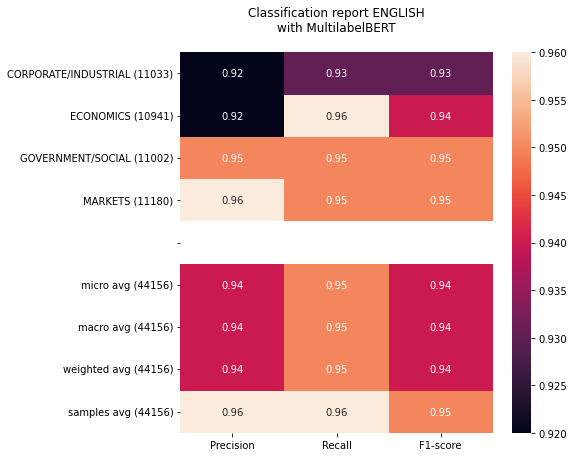

In [63]:
classification_report_=evalue('en')
plot_classification_report(classification_report_,title='ENGLISH\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.43494221123791527
F1 Score (Micro) = 0.7052029434652614
F1 Score (Macro) = 0.6805902225477203
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


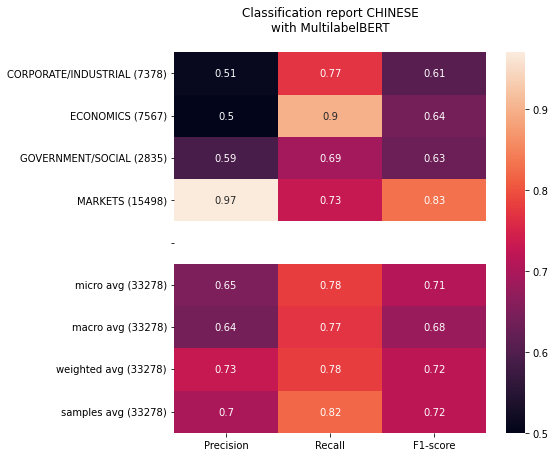

In [64]:
classification_report_=evalue('cn')
plot_classification_report(classification_report_,title='CHINESE\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.524674371674922
F1 Score (Micro) = 0.7318183409783255
F1 Score (Macro) = 0.6902062673268133
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


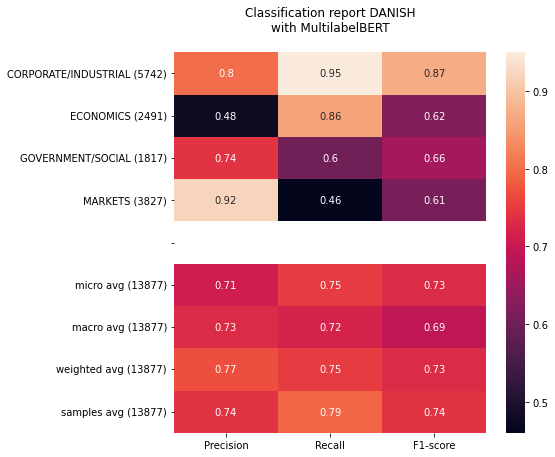

In [65]:
classification_report_=evalue('dk')
plot_classification_report(classification_report_,title='DANISH\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.7437325905292479
F1 Score (Micro) = 0.8546212306937975
F1 Score (Macro) = 0.6604669199294181
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:00s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


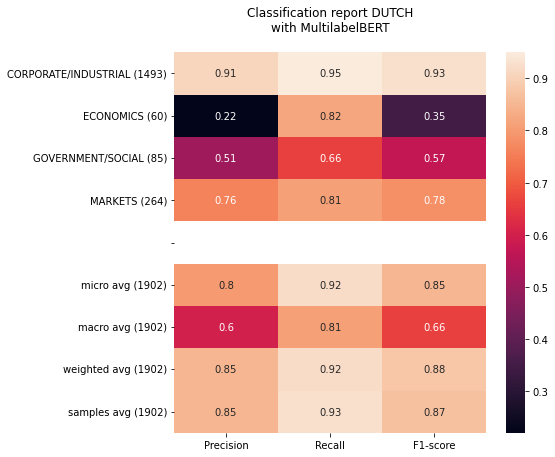

In [66]:
classification_report_=evalue('nl')
plot_classification_report(classification_report_,title='DUTCH\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.7543455829827764
F1 Score (Micro) = 0.862324477916632
F1 Score (Macro) = 0.8023583788376467
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


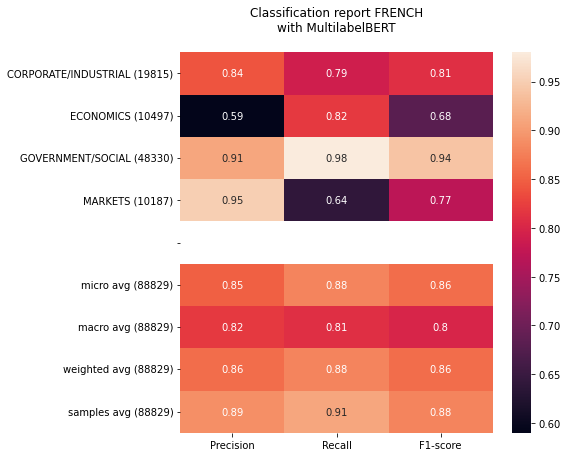

In [67]:
classification_report_=evalue('fr')
plot_classification_report(classification_report_,title='FRENCH\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.6017665208009841
F1 Score (Micro) = 0.808529479083415
F1 Score (Macro) = 0.7680728310842284
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:02s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


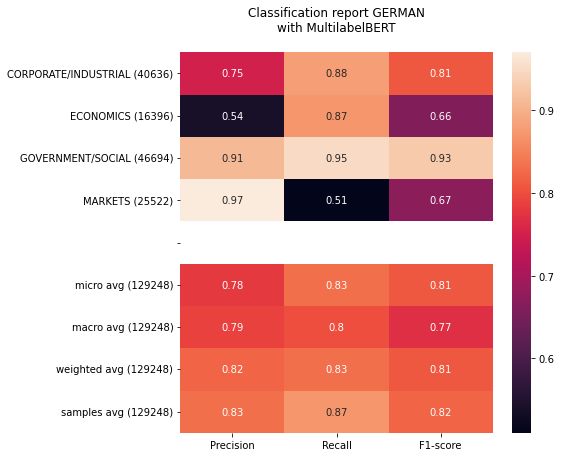

In [68]:
classification_report_=evalue('de')
plot_classification_report(classification_report_,title='GERMAN\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.512202293443105
F1 Score (Micro) = 0.7165263234971077
F1 Score (Macro) = 0.7171626286393792
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


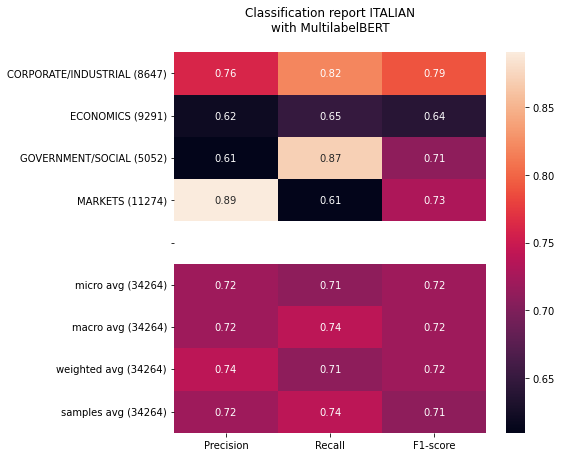

In [69]:
classification_report_=evalue('it')
plot_classification_report(classification_report_,title='ITALIAN\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.39877092316572166
F1 Score (Micro) = 0.6275321967878646
F1 Score (Macro) = 0.6113118764601781
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


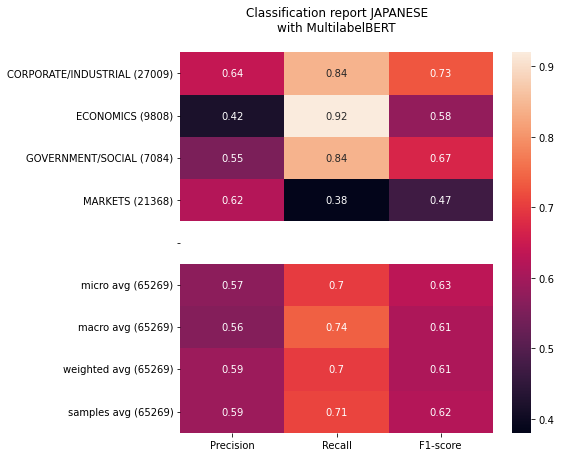

In [70]:
classification_report_=evalue('jp')
plot_classification_report(classification_report_,title='JAPANESE\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.6369773519163763
F1 Score (Micro) = 0.77982350042557
F1 Score (Macro) = 0.6488614188414269
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:00s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


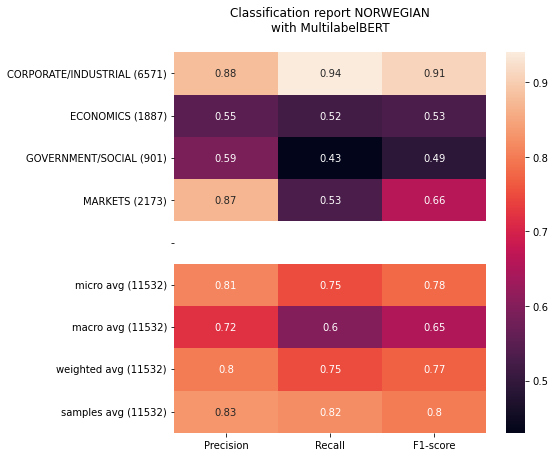

In [71]:
classification_report_=evalue('no')
plot_classification_report(classification_report_,title='NORWEGIAN\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.42614288996094646
F1 Score (Micro) = 0.7022558980540726
F1 Score (Macro) = 0.6898379004954417
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:00s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


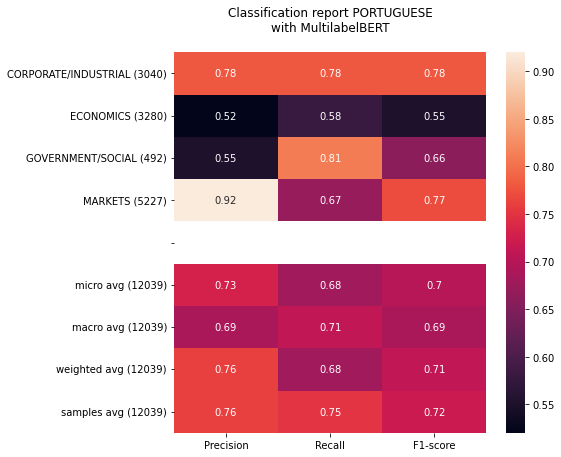

In [72]:
classification_report_=evalue('pt')
plot_classification_report(classification_report_,title='PORTUGUESE\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.3734395434549994
F1 Score (Micro) = 0.6541232484807985
F1 Score (Macro) = 0.649073742753576
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:00s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


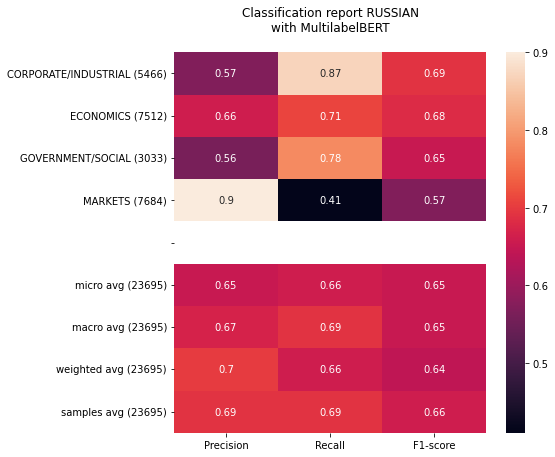

In [73]:
classification_report_=evalue('ru')
plot_classification_report(classification_report_,title='RUSSIAN\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.4757002103398649
F1 Score (Micro) = 0.6945885509838998
F1 Score (Macro) = 0.6992267752244616
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:00s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


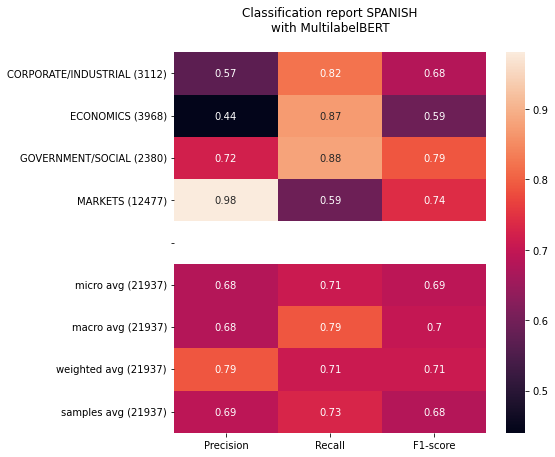

In [74]:
classification_report_=evalue('es')
plot_classification_report(classification_report_,title='SPANISH\nwith MultilabelBERT\n',size=(7,7))

In [75]:
# classification_report_=evalue('es-latam')
# plot_classification_report(classification_report_,title='SPANISH LATAM\nwith MultilabelBERT\n',size=(7,7))

START:  2022-02-16 16:12
----------------------------------------------------------------------------------------------------
Epoch: 0
Il file  esiste? True
Il file  esiste? True
Accuracy Score = 0.5697453688551417
F1 Score (Micro) = 0.7596622436670688
F1 Score (Macro) = 0.7188961932992739
END:  2022-02-16 16:12
tempo impiegato 0d:00h:00m:01s
----------------------------------------------------------------------------------------------------
START:  2022-02-16 16:12


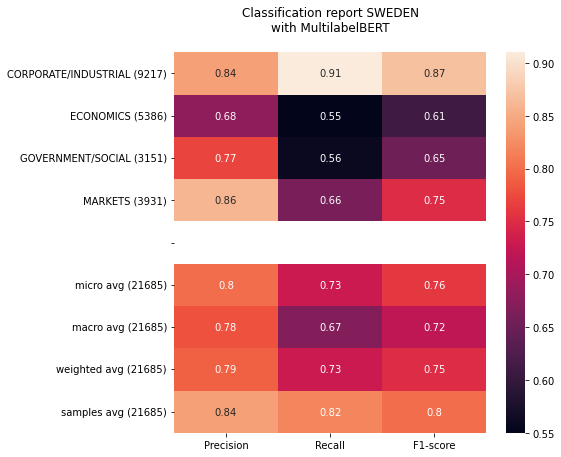

In [76]:
classification_report_=evalue('se')
plot_classification_report(classification_report_,title='SWEDEN\nwith MultilabelBERT\n',size=(7,7))